In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import columnas_utils as col
import pandas as pd
%cd ..\..\etabs_oapi
import sismo_utils as sis
import etabs_utils as etb
%cd ..\concreto\columnas

%matplotlib inline
%matplotlib notebook

D:\diseño\programas\ingenieria estructural\etabs_oapi
D:\diseño\programas\ingenieria estructural\concreto\columnas


## Diseño de Columnas

In [2]:
# Definicion de las unidades
N = 1
m = 1
cm = 1/100
Pa = 1
MPa = 10**6
pulg = 2.54 / 100

# Definicion de varillas de acero:
d_3 = 3/8 * pulg
d_4 = 1/4 * pulg
d_5 = 5/8 * pulg
d_6 = 3/4 * pulg
d_8 = 1 * pulg

A_3 = d_3 ** 2 /4 * math.pi
A_4 = d_4 ** 2 /4 * math.pi
A_5 = d_5 ** 2 /4 * math.pi
A_6 = d_6 ** 2 /4 * math.pi
A_8 = d_8 ** 2 /4 * math.pi

## Datos de la sección

In [3]:
#Dimensiones de la columna
geom = {'b':35*cm,
       'h':75*cm,
       'r':4*cm}

## Materiales

In [4]:
# Concreto
d_conc = {'fc': 21*MPa, #Resistencia a la compresion
          'eps_u':0.003} #Deformación unitaria ultima

#Acero de refuerzo
d_steel = {'fy' : 420*MPa, #Esfuerzo a la fluencia del acero
          'Es' : 200000*MPa, #Módulo de elasticidad del acero
          'eps_y' : 0.0021} #Deformación de fluencia del acero

## Acero de Refuerzo Colocado

In [5]:
steel = {'d_p' : d_5, #diámetro principal
        'd_s' : d_5, #diámetro secundario
        'd_st' : d_3, #diámetro del estribo
        'n_f' : 6, #filas de acero
        'n_c' : 3} #columnas de acero

#Procesando data de acero:
#(matriz de refuerzos, matriz de areas y Area de refuerzo):
reb_matx, area_matx, Aref = col.rebar_data(steel)

## Resistencia a la compresión pura de la Columna

In [6]:
phi = 0.65 #factor de minoración
Ag = geom['b']*geom['h']
fc = d_conc['fc']
fy = d_steel['fy']
P_n = 0.85*fc*(Ag-Aref)+Aref*fy #Resistemcia Nominal
phiP_n = phi*0.8*P_n #Resistencia reducida
print('Resistencia a la compresión pura reducida: {:.2f} N'.format(phiP_n))

Resistencia a la compresión pura reducida: 3016002.80 N


## Diseño a Flexocompresión

In [7]:
#Importación de cargas
cargas = pd.read_csv('cargas.csv',sep=';')

#Conversion de unidades
cargas.P = cargas.P*9.81*10**3
cargas.M2 = cargas.M2*9.81*10**3
cargas.M3 = cargas.M3*9.81*10**3

In [8]:
#Datos a flexocompresión
theta = np.array(range(21))*4.5

flex_comp_data = col.vector_function(col.flex_comp_data,theta,
                                     d_conc,d_steel,geom,steel,phi)

Pn = flex_comp_data[:,0]
phi_Pn = flex_comp_data[:,1]
Mn_x = flex_comp_data[:,2]
Mn_y = flex_comp_data[:,3]
phi_Mn_x = flex_comp_data[:,4]
phi_Mn_y = flex_comp_data[:,5]

<IPython.core.display.Javascript object>


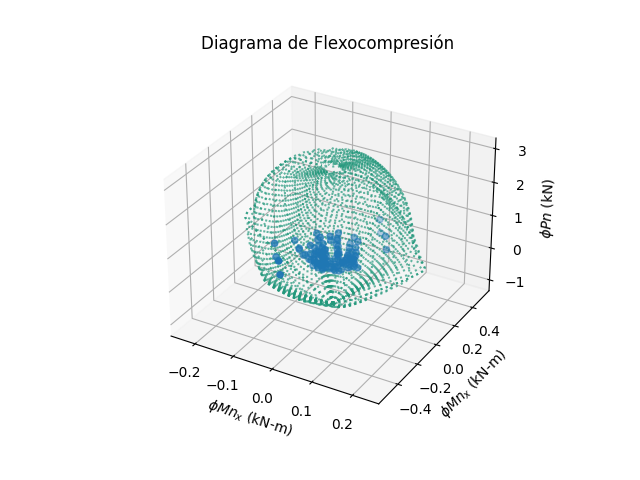

In [9]:
#Diagrama a flexocompresión
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i,theta_ in enumerate(theta):
    col.plot_flex_comp(phi_Pn[i],phi_Mn_x[i],phi_Mn_y[i],ax)
    
ax.scatter(cargas['M2']/10**6,cargas['M3']/10**6,cargas['P']*-1/10**6)
plt.title('Diagrama de Flexocompresión')
ax.set_xlabel("$\phi Mn_x$ (kN-m)")
ax.set_ylabel("$\phi Mn_x$ (kN-m)")
ax.set_zlabel("$\phi Pn$ (kN)")
plt.show()

<IPython.core.display.Javascript object>


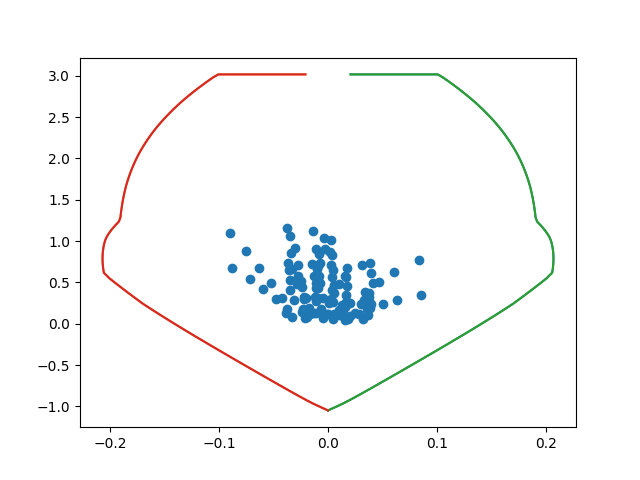

In [10]:
fig, ax = plt.subplots()
ax.plot(phi_Mn_x[1]/10**6, phi_Pn[1]/10**6)
ax.plot(-phi_Mn_x[1]/10**6, phi_Pn[1]/10**6)
ax.plot(phi_Mn_x[1]/10**6, phi_Pn[1]/10**6)
ax.plot(-phi_Mn_x[1]/10**6, phi_Pn[1]/10**6)
ax.scatter(cargas['M2']/10**6,cargas['P']*-1/10**6)
plt.show()

<IPython.core.display.Javascript object>


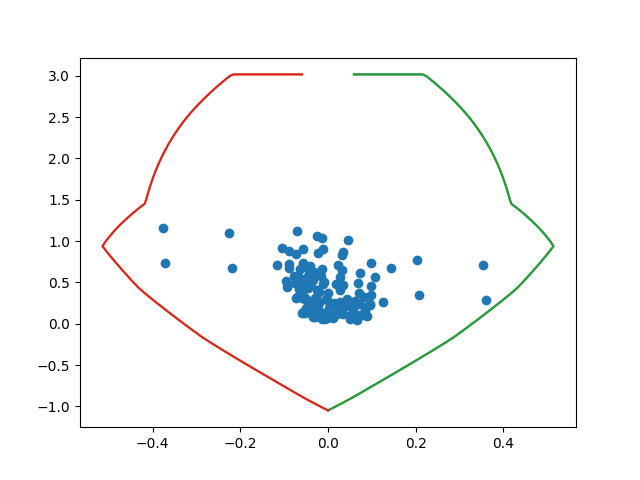

In [11]:
fig, ax = plt.subplots()
ax.plot(phi_Mn_y[-1]/10**6, phi_Pn[-1]/10**6)
ax.plot(-phi_Mn_y[-1]/10**6, phi_Pn[-1]/10**6)
ax.plot(phi_Mn_y[-1]/10**6, phi_Pn[-1]/10**6)
ax.plot(-phi_Mn_y[-1]/10**6, phi_Pn[-1]/10**6)
ax.scatter(cargas['M3']/10**6,cargas['P']*-1/10**6)
plt.show()

## Comprobación Viga débil Columna Fuerte

La resistencia a la flexión de las columnas debe ser por lo menos 6/5 de la resistencia a la flexion de la viga que se apoya en ella:

$ \hspace{5.5cm} \Sigma M_{nc} \geq (6/5) \Sigma M_{nb} $

In [12]:
#Datos de la viga
bv = 25*cm
hv = 40*cm
dv = hv-9*cm #peralte efectivo
As = 4*A_5 #4 aceros #5

#Momento Resistente máximo con acero en tracción solamente
phi_f = 0.9
av = As*fy/(0.5*fc*bv) #Altura del bloque en compresión
phi_Mnv = phi_f*As*fy*(dv-av/2)

## Momento nominal menor en la columna

In [13]:
#Elegimos la menor carga que no se encuetra en el último nivel
P_min = cargas[cargas.Piso!=6]['P'].max()

#Valor de a en el que se encuentra la carga mínima
